# Предсказание рейтинга ресторана на сайте TripAdvisor
Есть сведения о 50 000 ресторанах Европы, взятые с сайта TripAdvisor

**Цель**: самостоятельно очистить довольно сильно загрязнённый датасет, извлечь из него несколько новых признаков и подготовить данные для обучения модель.  Есть уже готовая модель, которая будет предсказывать рейтинг ресторана по данным сайта TripAdvisor на основе имеющихся в датасете данных.

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import os
from sklearn.model_selection import train_test_split
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [ ]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [112]:
df_train = pd.read_csv(
    'C:/Users/DariaMishina/skillfactory_rds/module_3/main_task.csv')
df_test = pd.read_csv(
    'C:/Users/DariaMishina/skillfactory_rds/module_3/kaggle_task.csv')
sample_submission = pd.read_csv(
    'C:/Users/DariaMishina/skillfactory_rds/module_3/sample_submission.csv')

In [113]:
# нашла датасет со столицами стран на kaggle, буду использовать для создания нового признака - является ли город столицей
capital = pd.read_csv(
    'C:/Users/DariaMishina/skillfactory_rds/module_3/concap.csv')

In [178]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['Rating'] = 0

data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем

In [6]:
# посмотрим на типы данных и количество пропусков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

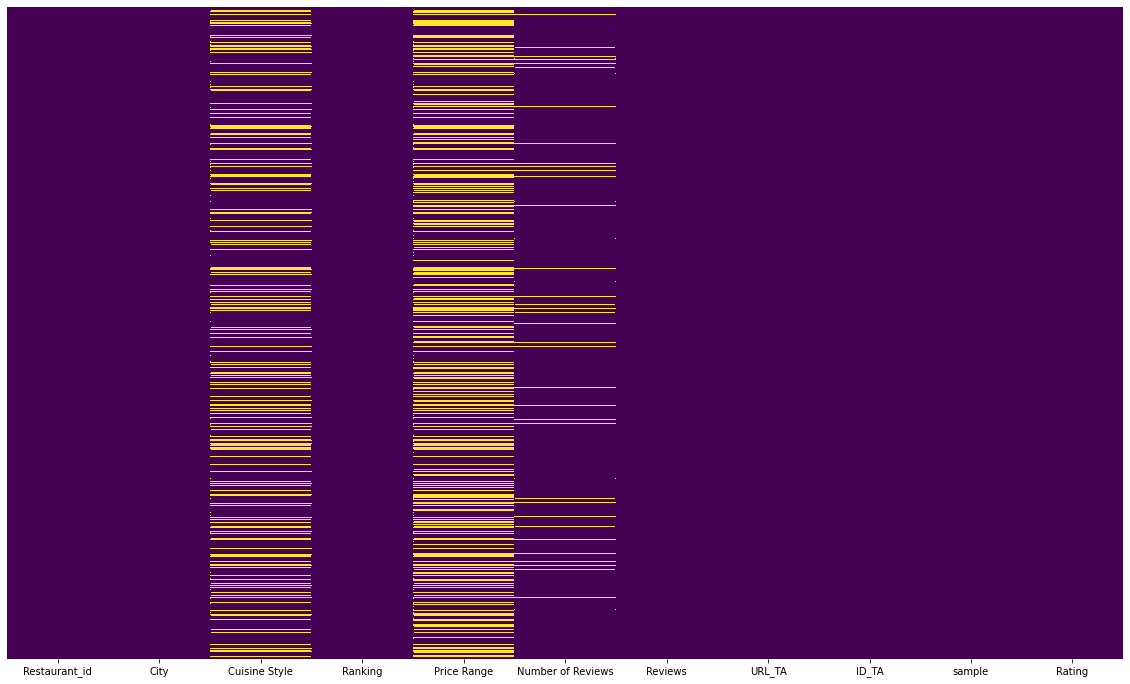

In [7]:
fig, ax = plt.subplots(figsize=(20, 12))
sns_heatmap = sns.heatmap(
    data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

**Целевая переменная (Rating)** - без пропусков

**Признаки без пропусков:**
* Restaurant_id
* City
* Ranking
* Reviews
* URL_TA
* ID_TA

**Числовой формат данных:**
* Ranking
* Rating - *целевая переменная*
* Number of Reviews

**Данные в смешанном формате** (похоже на список,но по факту - строка, есть дата и т.д.)
* Cuisine Style
* Reviews

In [8]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
28030,id_2070,Milan,"['Italian', 'Pizza']",2072.0,$$ - $$$,60.0,"[[], []]",/Restaurant_Review-g187849-d10367053-Reviews-W...,d10367053,1,4.0
43174,id_8031,Madrid,"['Cafe', 'Mediterranean', 'Spanish']",8038.0,$,37.0,"[['Small Coffee Shop', 'This place is a No-Go'...",/Restaurant_Review-g187514-d4750473-Reviews-Ca...,d4750473,1,2.5
42269,id_91,Rome,"['Greek', 'Vegetarian Friendly', 'Vegan Options']",92.0,$,800.0,"[['Outstanding bistrotype grecian', 'Satisfy Y...",/Restaurant_Review-g187791-d5960255-Reviews-Il...,d5960255,1,4.5
3622,id_3622,Stockholm,"['Bar', 'Pub', 'Irish']",916.0,$$ - $$$,37.0,[['Typical Irish pub with good beer selection'...,/Restaurant_Review-g189852-d1422242-Reviews-Li...,d1422242,0,0.0
17734,id_847,Paris,"['French', 'European', 'Vegetarian Friendly']",848.0,$$ - $$$,175.0,"[['Modern Restaurant & cuisine', 'A decent mea...",/Restaurant_Review-g187147-d7622753-Reviews-Le...,d7622753,1,4.5


In [9]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data

## Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [179]:
# В датасете 3 признака с пропусками, по всем 3м вынесем отсутствие информации в отдельный признак
data['Number_of_Reviews_isNAN'] = pd.isna(
    data['Number of Reviews']).astype('uint8')
data['Cuisine_Style_isNAN'] = pd.isna(data['Cuisine Style']).astype('uint8')
data['Price_Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')

**Number of Reviews** - пробовала заполнять пропуски модой, медианой, средним и нулем, лучшее значение МАЕ при заполнении нулем. Предположительно, пропуски - это случаи, когда клиент не написал отзыв, только поставил оценку

In [180]:
data['Number of Reviews'].fillna(0, inplace=True)

**Price Range** посмотрим на этот признак, какие он принимает значения и сколько пропусков

In [117]:
data['Price Range'].value_counts(dropna = False)

$$ - $$$    23041
NaN         17361
$            7816
$$$$         1782
Name: Price Range, dtype: int64

Признак ординальный (последовательный), нулем/средним заполнить не получится, заполним самым часто встречающимся значением, то есть средним ценовым диапазоном

In [181]:
data['Price Range'] = data['Price Range'].fillna(data['Price Range'].mode()[0])

**Cuisine Style** сложный признак, тип данных строка, а по факту это список. Заполним пропуски значением Other, позднее разберем на составляющие

In [182]:
data['Cuisine Style'] = data['Cuisine Style'].fillna("['Other']")

## Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [15]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    3
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
Cuisine_Style_isNAN            2
Price_Range_isNAN              2
dtype: int64

**интересное наблюдение** - Restaurant_id не уникальный признак и видимо не несет никакой ценной информации, удалим его

In [203]:
data.drop(['Restaurant_id'], axis=1, inplace=True)

### создадим новый признак Столица (бинарный) 

In [17]:
# сделаем из колонки в найденном на kaggle датафрейме (сериз) - список, так удобнее искать
caplist = capital.CapitalName.to_list()
caplist

['Hargeisa',
 'King Edward Point',
 'Port-aux-Français',
 'Jerusalem',
 'Mariehamn',
 'Yaren',
 'Marigot',
 'Atafu',
 'El-Aaiún',
 'Kabul',
 'Tirana',
 'Algiers',
 'Pago Pago',
 'Andorra la Vella',
 'Luanda',
 'The Valley',
 "Saint John's",
 'Buenos Aires',
 'Yerevan',
 'Oranjestad',
 'Canberra',
 'Vienna',
 'Baku',
 'Nassau',
 'Manama',
 'Dhaka',
 'Bridgetown',
 'Minsk',
 'Brussels',
 'Belmopan',
 'Porto-Novo',
 'Hamilton',
 'Thimphu',
 'La Paz',
 'Sarajevo',
 'Gaborone',
 'Brasilia',
 'Road Town',
 'Bandar Seri Begawan',
 'Sofia',
 'Ouagadougou',
 'Rangoon',
 'Bujumbura',
 'Phnom Penh',
 'Yaounde',
 'Ottawa',
 'Praia',
 'George Town',
 'Bangui',
 "N'Djamena",
 'Santiago',
 'Beijing',
 'The Settlement',
 'West Island',
 'Bogota',
 'Moroni',
 'Kinshasa',
 'Brazzaville',
 'Avarua',
 'San Jose',
 'Yamoussoukro',
 'Zagreb',
 'Havana',
 'Willemstad',
 'Nicosia',
 'Prague',
 'Copenhagen',
 'Djibouti',
 'Roseau',
 'Santo Domingo',
 'Quito',
 'Cairo',
 'San Salvador',
 'Malabo',
 'Asmara',
 '

In [183]:
data['is_capital'] = data.City.apply(lambda x: 1 if x in caplist else 0)

### добавим новый признак - кол-во ресторанов в городе

посмотрим, сколько ресторанов в каждом из 31 городе

In [19]:
data['City'].value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

In [184]:
rest_in_city = data['City'].value_counts()
data['Rest_in_city'] = data['City'].apply(lambda x: rest_in_city[x])

### добавим новый признак - Население в городе
городов всего 31 штука, на kaggle не нашла датасета с населением, пришлось воспользоваться википедией и гуглом

In [83]:
population = {
    'London': 8173900,
    'Paris': 2240621,
    'Madrid': 3155360,
    'Barcelona': 1593075,
    'Berlin': 3326002,
    'Milan': 1331586,
    'Rome': 2870493,
    'Prague': 1272690,
    'Lisbon': 547733,
    'Vienna': 1765649,
    'Amsterdam': 825080,
    'Brussels': 144784,
    'Hamburg': 1718187,
    'Munich': 1364920,
    'Lyon': 496343,
    'Stockholm': 1981263,
    'Budapest': 1744665,
    'Warsaw': 1720398,
    'Dublin': 506211,
    'Copenhagen': 1246611,
    'Athens': 3168846,
    'Edinburgh': 476100,
    'Zurich': 402275,
    'Oporto': 221800,
    'Geneva': 196150,
    'Krakow': 756183,
    'Oslo': 673469,
    'Helsinki': 574579,
    'Bratislava': 413192,
    'Luxembourg': 576249,
    'Ljubljana': 277554
}

In [185]:
data['Population'] = data['City'].map(population)

### добавим новый признак - рестораннообеспеченность или кол-во ресторанов на человека

In [186]:
data['Rest_per_man'] = data['Population'] / data['Rest_in_city']

### добавим новый признак - Country
городов немного, создала словарь руками, сокращенные названия стран добавила отсюда
https://www.acex.net/ru/useful_information/ISO_country_codes.php

In [187]:
country = {
    'London': 'GB',
    'Paris': 'FR',
    'Madrid': 'ES',
    'Barcelona': 'ES',
    'Berlin': 'DE',
    'Milan': 'IT',
    'Rome': 'IT',
    'Prague': 'CZ',
    'Lisbon': 'PT',
    'Vienna': 'AT',
    'Amsterdam': 'NL',
    'Brussels': 'BE',
    'Hamburg': 'DE',
    'Munich': 'DE',
    'Lyon': 'FR',
    'Stockholm': 'SE',
    'Budapest': 'HU',
    'Warsaw': 'PL',
    'Dublin': 'IE',
    'Copenhagen': 'DK',
    'Athens': 'GR',
    'Edinburgh': 'GB',
    'Zurich': 'CH',
    'Oporto': 'PT',
    'Geneva': 'CH',
    'Krakow': 'PL',
    'Oslo': 'NO',
    'Helsinki': 'FI',
    'Bratislava': 'SK',
    'Luxembourg': 'LU',
    'Ljubljana': 'SI'
}

data['Country'] = data['City'].apply(lambda x: country[x])

посмотрим, сколько получилось стран

In [155]:
data['Country'].nunique()

22

и сколько ресторанов в каждой стране

In [26]:
data['Country'].value_counts()

GB    7938
FR    7234
ES    7208
IT    5283
DE    5036
PT    2289
CZ    1816
PL    1479
AT    1443
NL    1372
BE    1314
CH    1275
SE    1033
HU    1021
IE     836
DK     819
GR     776
NO     488
FI     475
SK     380
LU     263
SI     222
Name: Country, dtype: int64

### добавим новый признак - кол-во ресторанов в стране

In [188]:
rest_in_country = data['Country'].value_counts()
data['Rest_in_country'] = data['Country'].apply(lambda x: rest_in_country[x])

### добавим новый признак, точней 31 новый признак по городам

In [189]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
# Add a column to indicate NaNs, if False NaNs are ignored.
data = pd.get_dummies(data, columns=['City', ], dummy_na=True)

### добавим новый признак, точней 22 новых признака по странам

In [190]:
data = pd.get_dummies(data, columns=[ 'Country',], dummy_na=True)

__Возьмем следующий признак "Price Range"__

In [28]:
data['Price Range'].value_counts()

$$ - $$$    40402
$            7816
$$$$         1782
Name: Price Range, dtype: int64

### создадим новый признак (бинарный) - цены средние или нет

добавление признакак ухудшило МАЕ, закомментируем его

In [90]:
#data['Price Category'] = data['Price Range'].apply(lambda x: x!= '$$ - $$$') 
#data['Price Category'] = data['Price Category'].astype(int)

### создадим новый признак, точней 3 признака для каждого диапазона цен

**1й вариант - One hot encoding** МАЕ ухудшился, закомментируем этот вариант

In [176]:
# dummy_na=True убрала, так как уже все пропуски ранее заполнила
#data = pd.get_dummies(data, columns=['Price Range', ])

**2й вариант - LabelEncoding**
МАЕ для второго вариант лучше

In [30]:
from sklearn.preprocessing import LabelEncoder

In [191]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
data['Price Range_Cat'] = labelencoder.fit_transform(data['Price Range'])

__рассмотрим следующий признак Reviews__
внутри этот признак содержит дату отзывов, попробуем ее достать

### создадим новый признак - кол-во дней между отзывами

In [192]:
# заполняем пропуски
data['Reviews'] = data['Reviews'].fillna("['no_Reviews']")
# создаем новую колонку и туда кладем только данные, ктр содержат дату
data['date_of_Review'] = data['Reviews'].str.findall('\d+/\d+/\d+')
# создаем новую колонку, ктр содержит разницу между значениями колонки date_of_Review и превращаем ее в дни
data['day_between_Reviews'] = data.apply(lambda x: pd.to_datetime(
    x['date_of_Review']).max() - pd.to_datetime(x['date_of_Review']).min(), axis=1).dt.days

In [33]:
#проверяем, что получилось
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Cuisine Style            50000 non-null  object 
 1   Ranking                  50000 non-null  float64
 2   Price Range              50000 non-null  object 
 3   Number of Reviews        50000 non-null  float64
 4   Reviews                  50000 non-null  object 
 5   URL_TA                   50000 non-null  object 
 6   ID_TA                    50000 non-null  object 
 7   sample                   50000 non-null  int64  
 8   Rating                   50000 non-null  float64
 9   Number_of_Reviews_isNAN  50000 non-null  uint8  
 10  Cuisine_Style_isNAN      50000 non-null  uint8  
 11  Price_Range_isNAN        50000 non-null  uint8  
 12  is_capital               50000 non-null  int64  
 13  Rest_in_city             50000 non-null  int64  
 14  Population            

не все отзывы содержат дату, поэтому незаполненные значения заполним нулем

In [193]:
data['day_between_Reviews'].fillna(0, inplace=True)

### Создадим новый признак - разница между отзывами больше/меньше год

добавление признакак ухудшило МАЕ, закомментируем его

In [94]:
#сравниваем сроки между отзывами с годом
#data['Old']=data['day_between_Reviews'].apply(lambda x: float(x)>float(365)) 
#конвертируем буллево значение в 0/1
#data['Old'] = data['Old'].astype(int)

### создадим новый признак - кол-во прошедших дней с последнего отзыва

In [45]:
from datetime import datetime

In [194]:
data['day_from_last_review'] = data.apply(lambda x: pd.datetime.now(
) - pd.to_datetime(x['date_of_Review']).max(), axis=1).dt.days

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


проверяем, что получилось

In [195]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 77 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Restaurant_id            50000 non-null  object 
 1   Cuisine Style            50000 non-null  object 
 2   Ranking                  50000 non-null  float64
 3   Price Range              50000 non-null  object 
 4   Number of Reviews        50000 non-null  float64
 5   Reviews                  50000 non-null  object 
 6   URL_TA                   50000 non-null  object 
 7   ID_TA                    50000 non-null  object 
 8   sample                   50000 non-null  int64  
 9   Rating                   50000 non-null  float64
 10  Number_of_Reviews_isNAN  50000 non-null  uint8  
 11  Cuisine_Style_isNAN      50000 non-null  uint8  
 12  Price_Range_isNAN        50000 non-null  uint8  
 13  is_capital               50000 non-null  int64  
 14  Rest_in_city          

и опять есть пропуски, заполним их нулем

In [196]:
data['day_from_last_review'].fillna(0, inplace=True)

__рассмотрим следующий признак Cuisine Style__

пропуски на other мы уже заменили, посмотрим, сколько всего разных кухонь, много ли уникальных значений

In [197]:
# копируем датафрейм
data_copy = data.copy()
# создаем новую колонку в копии датафрейма - в каждой строке новой колонки список из рассплитованных  значений
data_copy['Cuisine'] = data['Cuisine Style'].str.findall(r"'(\b.*?\b)'")
# 'раздвигаем' исходный датасет, чтобы внутри признака было только одно значение вида кухни, а не список
data_copy = data_copy.explode('Cuisine')

In [198]:
data_copy['Cuisine'].value_counts()

Vegetarian Friendly    14021
European               12561
Other                  11590
Mediterranean           7820
Italian                 7433
                       ...  
Fujian                     2
Burmese                    1
Xinjiang                   1
Latvian                    1
Salvadoran                 1
Name: Cuisine, Length: 126, dtype: int64

уникальных значений (кухонь, ктр встречаются только в одном ресторане) не так уж и много, всего 4. Поэтому не будем выносить это в отдельный признак

### создадим новый признак - кол-во кухонь в одном ресторане

In [199]:
data['Number_of_cuisines'] = data['Cuisine Style'].apply(
    lambda x: len(x.split(',')))

посчитаем среднее значение для кол-ва кухонь в одном ресторане

In [99]:
aver_cuis = data['Cuisine Style'].apply(
    lambda x: len(x.split(','))).sum()/len(data)

### создадим новый признак больше или меньше среднего значения кухонь в одном ресторане

добавление признакак ухудшило МАЕ, закомментируем его

In [100]:
#сравниваем кол-во кухонь в ресторане со средним значением
#data['More/less_aver_cuis']=data['Number_of_cuisines'].apply(lambda x: x > aver_cuis) 
#конвертируем буллево значение в 0/1
#data['More/less_aver_cuis'] = data['More/less_aver_cuis'].astype(int)

# EDA 


### Посмотрим распределение признака Ranking

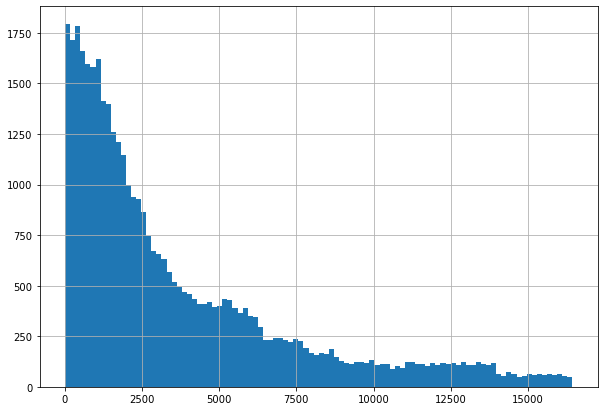

In [55]:
plt.rcParams['figure.figsize'] = (10, 7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

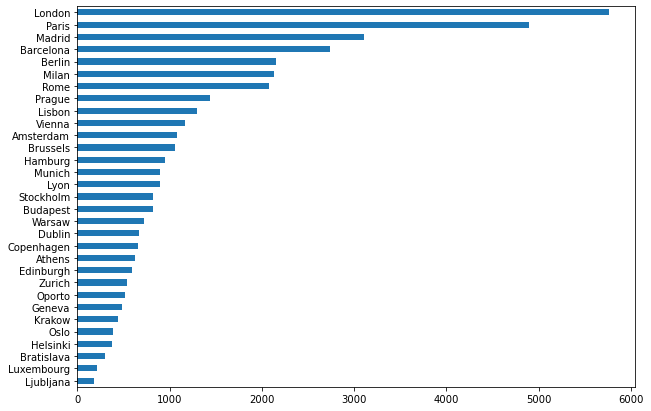

In [56]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

Посмотрим, как изменится распределение в большом городе:

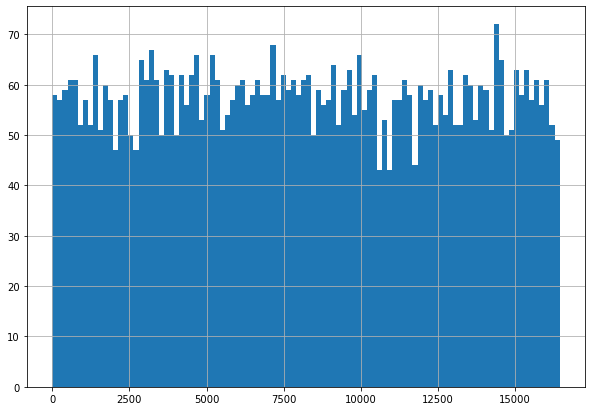

In [57]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

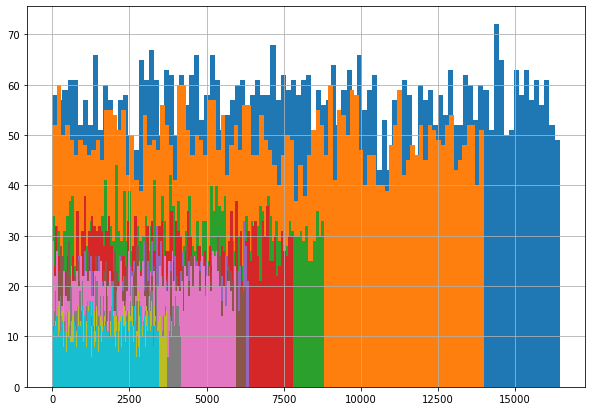

In [58]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

Получаается, что признак Ranking несколько субъективен и зависит от количества ресторанов в городе, а много ресторанов именно в большом городе, потому что если ресторан занимает 10е место из 10000, то он отличный, а если 10е место из 20, то он может быть и средним, и вообще плохим, так как в в маленьком городе мало выбора.

Введем параметр Comp_Ranking - сравнительный ранг = ранг / кол-во ресторанов в городе.

### добавим новый признак  - сравнительный ранг ресторана в городе

In [200]:
data['Comp_Ranking'] = data['Ranking'] / data['Rest_in_city']

сделаем аналогичный анализ, но уже по странам

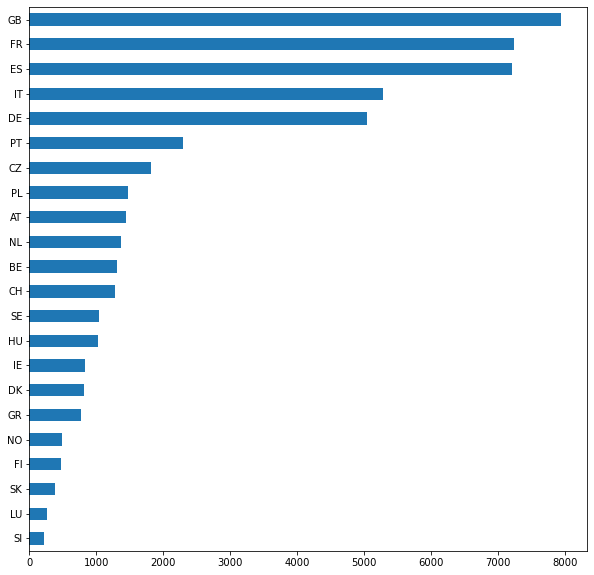

In [156]:
data['Country'].value_counts(ascending=True).plot(kind='barh')

посмотрим на распределение в стране с самым большим кол-вом ресторанов

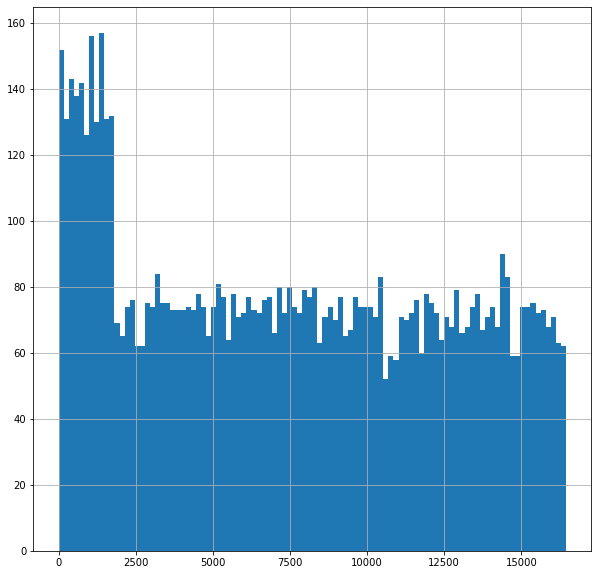

In [157]:
data['Ranking'][data['Country'] =='GB'].hist(bins=100)

есть перепад в самом начале

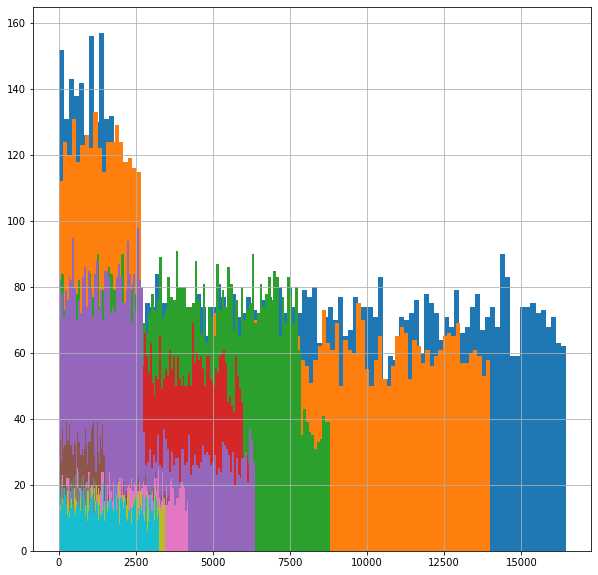

In [158]:
# посмотрим на топ 10 стран
for x in (data['Country'].value_counts())[0:10].index:
    data['Ranking'][data['Country'] == x].hist(bins=100)
plt.show()

Распределение по странам похоже на экспоненциальное, в качестве улучшения признаков можно попробовать прологарифмировать или извлечь корень из  Ranking по странам и если будет распределен нормально, то создать новый признак. Пока этого делать не будем, просто обозначим возможность улучшения модели

### Посмотрим распределение целевой переменной

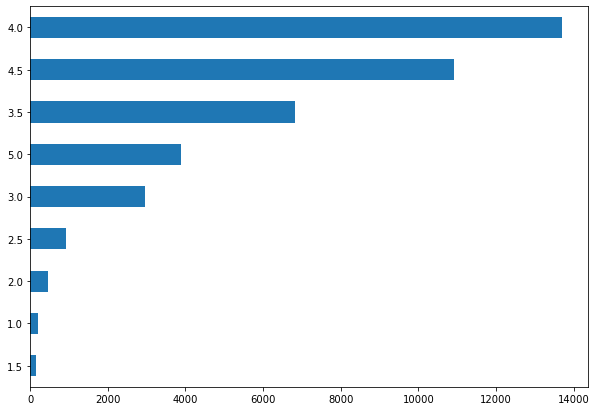

In [60]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

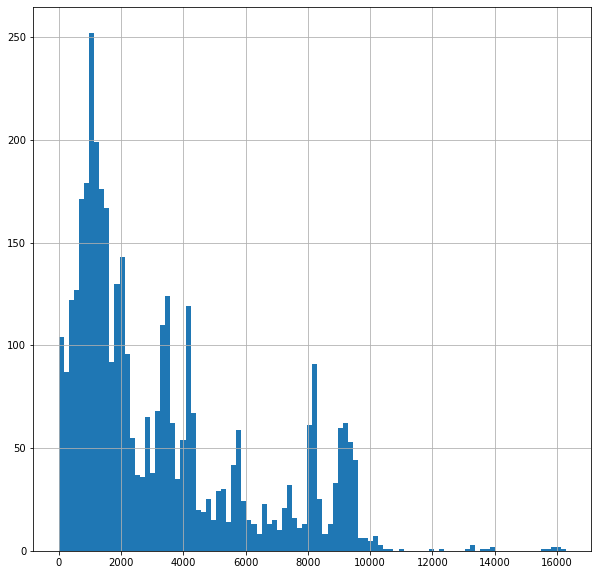

In [159]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

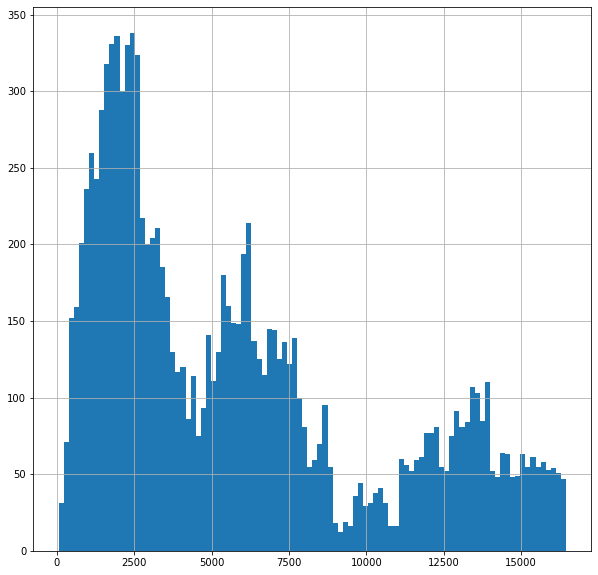

In [160]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### Корреляция

перед тем, как вывести тепловую карту с корреляцией, удалим все категориальные признаки

In [201]:
data.drop(['Cuisine Style', 'Price Range', 'Reviews', 'URL_TA', 'ID_TA', 'date_of_Review'], axis=1, inplace=True)

In [204]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 72 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Ranking                  50000 non-null  float64
 1   Number of Reviews        50000 non-null  float64
 2   sample                   50000 non-null  int64  
 3   Rating                   50000 non-null  float64
 4   Number_of_Reviews_isNAN  50000 non-null  uint8  
 5   Cuisine_Style_isNAN      50000 non-null  uint8  
 6   Price_Range_isNAN        50000 non-null  uint8  
 7   is_capital               50000 non-null  int64  
 8   Rest_in_city             50000 non-null  int64  
 9   Population               50000 non-null  int64  
 10  Rest_per_man             50000 non-null  float64
 11  Rest_in_country          50000 non-null  int64  
 12  City_Amsterdam           50000 non-null  uint8  
 13  City_Athens              50000 non-null  uint8  
 14  City_Barcelona        

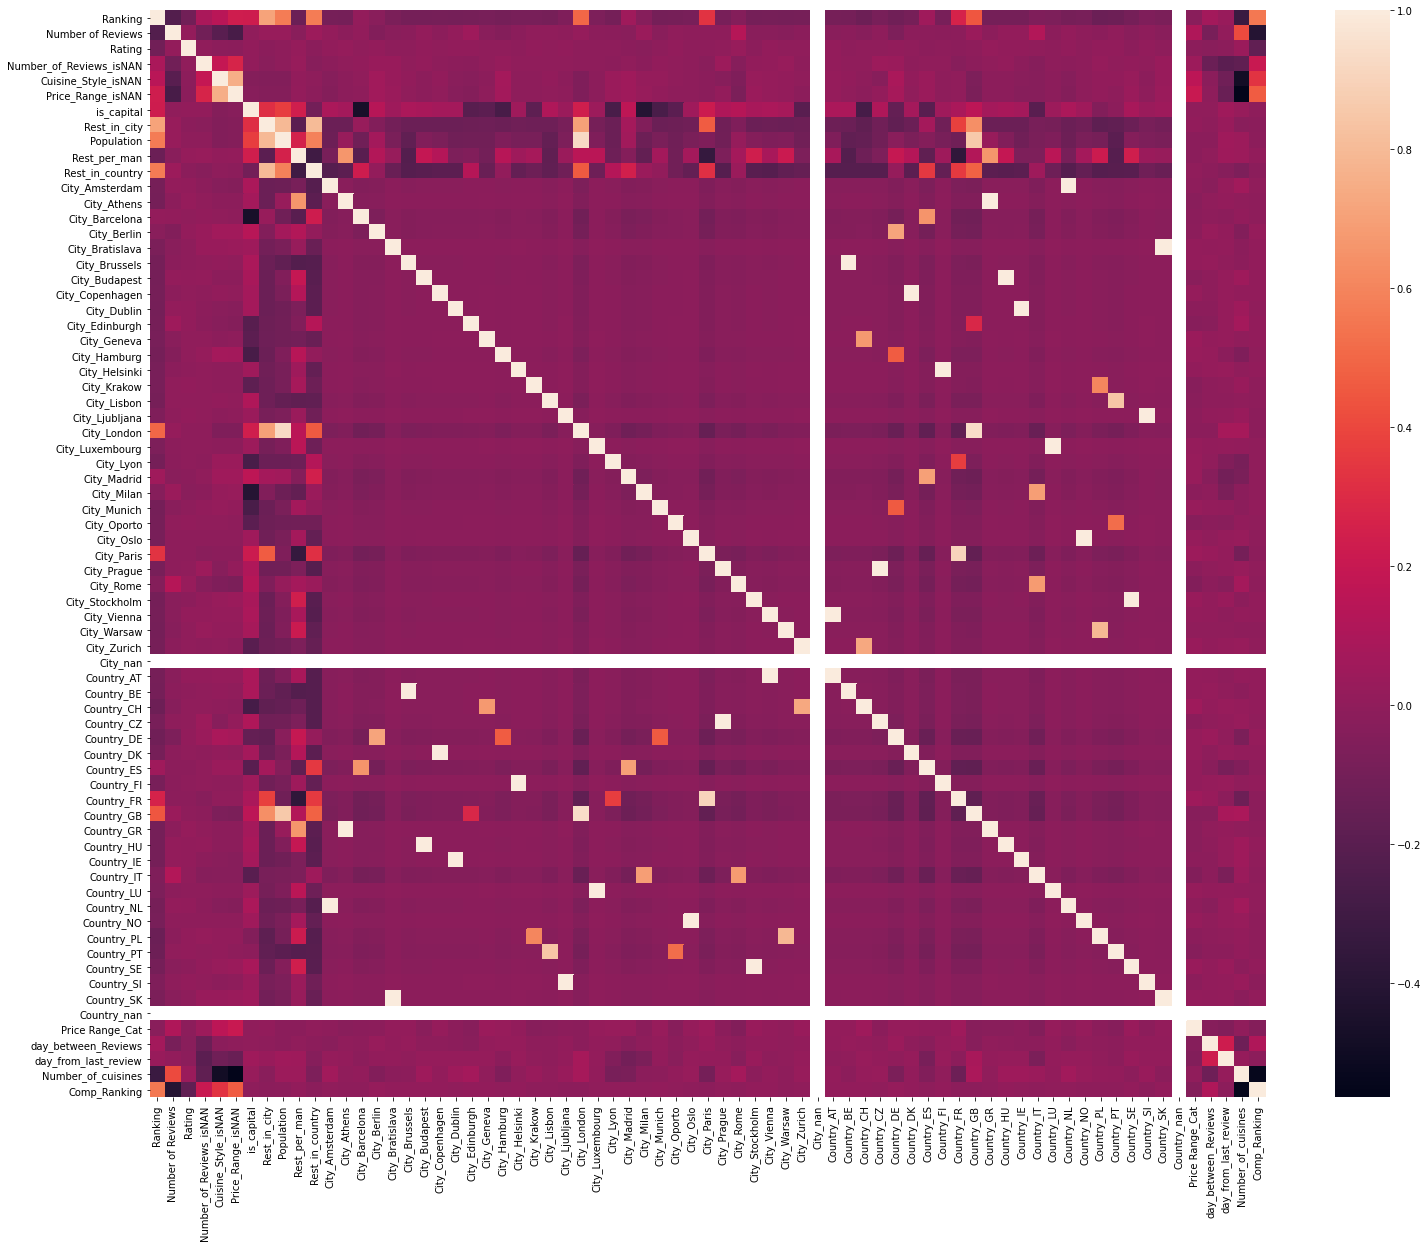

In [205]:
plt.rcParams['figure.figsize'] = (25,20)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Есть сильно скоррелированные параметры, но поскольку модель у нас уже выбрана и это случайный лес, то удалять ничего не будем, так как для случайного леса мультиколлинеарность не проблема, как и не проблема распределение, не являющееся нормальным

In [206]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [207]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [208]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 71), (40000, 71), (40000, 70), (32000, 70), (8000, 70))

# Model 
Сам ML

In [209]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [210]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [211]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [212]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.2022425


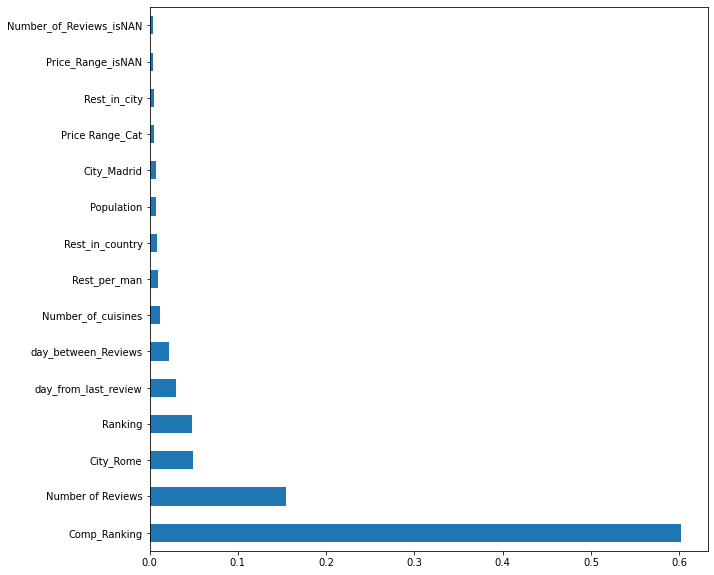

In [213]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [214]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNAN,Price_Range_isNAN,is_capital,Rest_in_city,Population,Rest_per_man,...,Country_PT,Country_SE,Country_SI,Country_SK,Country_nan,Price Range_Cat,day_between_Reviews,day_from_last_review,Number_of_cuisines,Comp_Ranking
7706,1254.0,48.0,0.0,0,0,1,0,1126,496343,440.801954,...,0,0,0,0,0,1,0.0,0.0,2,1.113677
7171,202.0,99.0,0.0,0,0,0,1,776,3168846,4083.564433,...,0,0,0,0,0,0,42.0,922.0,5,0.260309
1626,3841.0,17.0,0.0,0,0,0,1,1816,1272690,700.820485,...,0,0,0,0,0,1,79.0,1360.0,1,2.115088
6567,12303.0,27.0,0.0,0,0,0,1,6108,2240621,366.833824,...,0,0,0,0,0,0,124.0,1077.0,1,2.014244
4296,14043.0,2.0,0.0,0,1,1,1,7193,8173900,1136.368692,...,0,0,0,0,0,1,195.0,1338.0,1,1.952315
6375,1389.0,27.0,0.0,0,0,0,1,1816,1272690,700.820485,...,0,0,0,0,0,1,195.0,924.0,4,0.764868
6926,1260.0,85.0,0.0,0,0,0,1,1372,825080,601.370262,...,0,0,0,0,0,1,35.0,999.0,3,0.918367
8731,12486.0,5.0,0.0,0,1,1,1,6108,2240621,366.833824,...,0,0,0,0,0,1,0.0,996.0,1,2.044204
5010,8992.0,2.0,0.0,0,1,1,1,7193,8173900,1136.368692,...,0,0,0,0,0,1,561.0,1327.0,1,1.250104
428,2614.0,236.0,0.0,0,0,0,1,2589,2870493,1108.726535,...,0,0,0,0,0,1,53.0,1329.0,5,1.009656


In [215]:
test_data = test_data.drop(['Rating'], axis=1)

In [216]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [217]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [218]:
predict_submission

array([3.065, 4.19 , 4.475, ..., 3.025, 4.49 , 4.39 ])

In [219]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.065
1,id_1,4.190
2,id_2,4.475
3,id_3,4.295
4,id_4,4.450
5,id_5,4.445
6,id_6,2.935
7,id_7,2.370
8,id_8,4.075
9,id_9,4.620
